In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# sklearn stuff
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#yellobrick stuff
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def imply_season(month):
    return 'Summer' if month in [12, 1, 2] else 'Fall' if month in [3, 4, 5] else 'Spring' if month in [9, 10, 11] else 'Winter' 

def analyze_classifier(model, X_train, X_test, y_train, y_test, response='Response', classes=['No', 'Yes']):
    matrix = ConfusionMatrix(model, classes=classes)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, classes=classes, support=True)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model, classes=classes)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    disc_thresh = DiscriminationThreshold(model)
    disc_thresh.fit(X_train, y_train.values.ravel())
    disc_thresh.show()
    recall = PrecisionRecallCurve(model)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    return disc_thresh.thresholds_, disc_thresh.cv_scores_

def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        #print(exog)
        not_exog = [i for i in exogs if i != exog]
        #print(not_exog)
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    #create a df of predictions and probabilities
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']), predictions], axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={0:'No_Predicted',
                            1:'Yes_Predicted'}, 
                  index={0:'No_True',
                            1:'Yes_True'},
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),5), matrix, predicted_probs
    

### Load/Clean Data

In [3]:
data = pd.read_csv('..//Data//weatherAUS.csv')
data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Season'] =  data['Month'].apply(lambda x: imply_season(x)).astype('category')
data['Month'] = data['Month'].astype('category')
data['Response'] = data['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0) 
data['RainTomorrow'] = data['RainTomorrow'].astype('category')
data['WindGustDir'] = data['WindGustDir'].astype('category')
data['WindDir9am'] = data['WindDir9am'].astype('category')
data['WindDir3pm'] = data['WindDir3pm'].astype('category')
data['RainToday'] = data['RainToday'].astype('category')
data['Location'] = data['Location'].astype('category')

#OHE wind directions and RainToday (label encoder assumes ordinal?)
data.drop(columns=['Date', 'RISK_MM'], inplace=True)
data.dtypes

Location         category
MinTemp           float64
MaxTemp           float64
Rainfall          float64
Evaporation       float64
Sunshine          float64
WindGustDir      category
WindGustSpeed     float64
WindDir9am       category
WindDir3pm       category
WindSpeed9am      float64
WindSpeed3pm      float64
Humidity9am       float64
Humidity3pm       float64
Pressure9am       float64
Pressure3pm       float64
Cloud9am          float64
Cloud3pm          float64
Temp9am           float64
Temp3pm           float64
RainToday        category
RainTomorrow     category
Month            category
Season           category
Response            int64
dtype: object

In [4]:
data.groupby(['RainTomorrow'])[['Response']].mean().sort_values(['Response'], ascending=False)

,Response
RainTomorrow,
Yes,1
No,0


In [5]:
data.groupby(['Location'])[['Response']].mean().sort_values(['Response'], ascending=False).head(10)
#let's look for a more logical grouping than location.... 

,Response
Location,
Portland,0.365487
Walpole,0.336644
Cairns,0.317938
Dartmoor,0.313286
NorfolkIsland,0.310054
MountGambier,0.303630
Albany,0.299072
Witchcliffe,0.297764
CoffsHarbour,0.294277


In [6]:
data.groupby(['Month'])[['Response']].mean().sort_values(['Response'], ascending=False)

,Response
Month,
7,0.269208
6,0.261845
8,0.252508
9,0.229705
5,0.225278
4,0.217849
3,0.213332
11,0.212547
2,0.209691


In [7]:
data.groupby(['Season'])[['Response']].mean().sort_values(['Response'], ascending=False)

,Response
Season,
Winter,0.261202
Fall,0.218868
Spring,0.212424
Summer,0.203030


In [8]:
data.groupby(['RainToday'])[['Response']].mean().sort_values(['Response'], ascending=False)

,Response
RainToday,
Yes,0.464060
No,0.151868


Text(0, 0.5, 'Rain Freq')

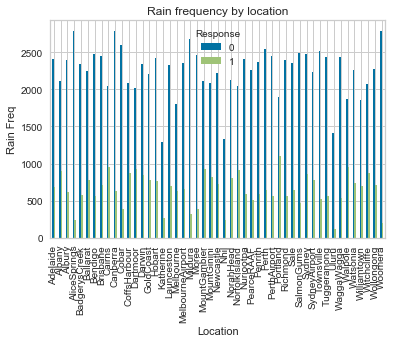

In [9]:
%matplotlib inline
pd.crosstab(data.Location, data.Response).plot(kind='bar')
plt.title('Rain frequency by location')
plt.xlabel('Location')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

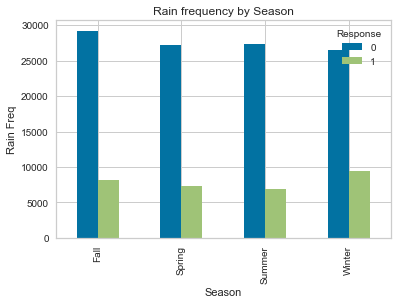

In [10]:
%matplotlib inline
pd.crosstab(data.Season, data.Response).plot(kind='bar')
plt.title('Rain frequency by Season')
plt.xlabel('Season')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

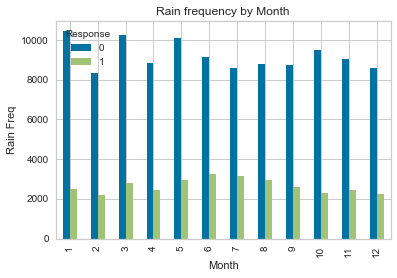

In [11]:
%matplotlib inline
pd.crosstab(data.Month, data.Response).plot(kind='bar')
plt.title('Rain frequency by Month')
plt.xlabel('Month')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

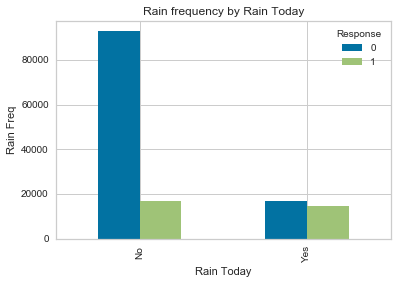

In [12]:
%matplotlib inline
pd.crosstab(data.RainToday, data.Response).plot(kind='bar')
plt.title('Rain frequency by Rain Today')
plt.xlabel('Rain Today')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

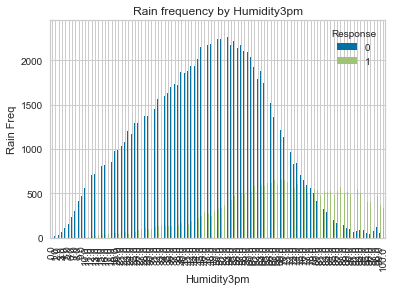

In [13]:
%matplotlib inline
pd.crosstab(data.Humidity3pm, data.Response).plot(kind='bar')
plt.title('Rain frequency by Humidity3pm')
plt.xlabel('Humidity3pm')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

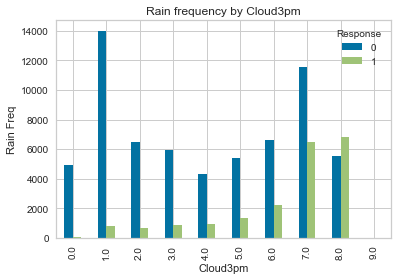

In [14]:
%matplotlib inline
pd.crosstab(data.Cloud3pm, data.Response).plot(kind='bar')
plt.title('Rain frequency by Cloud3pm')
plt.xlabel('Cloud3pm')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

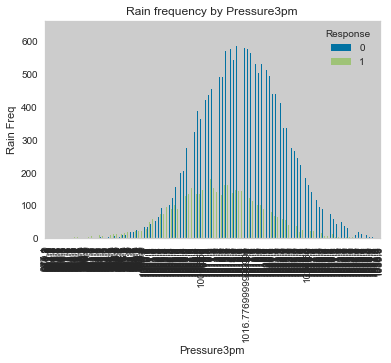

In [15]:
%matplotlib inline
pd.crosstab(data.Pressure3pm, data.Response).plot(kind='bar')
plt.title('Rain frequency by Pressure3pm')
plt.xlabel('Pressure3pm')
plt.ylabel('Rain Freq')

In [16]:
data.groupby(['WindDir9am'])[['Response']].mean().sort_values(['Response'], ascending=False)

,Response
WindDir9am,
NNW,0.309949
N,0.308084
NW,0.279350
WNW,0.270781
NNE,0.268873
W,0.261138
WSW,0.247260
SW,0.231759
SSW,0.220865


### Data Transforms

    - OHE Encode all categoricals
    - Standard Scale all numerics (sklearn is not R - it does not do this by default)
    - This needs to be done on train/test set separately (create a pipeline) 
    
    https://scikit-learn.org/stable/modules/cross_validation.html
    
    https://scikit-learn.org/stable/modules/compose.html#combining-estimators

In [18]:
data_final = data
#OH encode 
label_encode = [x for x, y in dict(data_final.dtypes).items() if type(y) == pd.CategoricalDtype]
for var in label_encode:
    #impute to Mode
    print(f"{var} was OHE'd")
    data_final[var].fillna(data_final[var].mode()[0], inplace=True)
    cat_list = f'var_{var}'
    cat_list = pd.get_dummies(data[var], prefix=var)
    data_new = data_final.join(cat_list)
    data_final = data_new

normalize =  [x for x, y in dict(data_final.dtypes).items() if y == np.float64]
for col in normalize:
        #change impution scheme?
        print(f"{col} was Standard Scaled")
        data_final[col].fillna(data_final[col].median(), inplace=True)
        normalizer = StandardScaler()
        ar = data_final[col].to_numpy().reshape(-1, 1)
        normalizer.fit(ar)
        data_final.loc[:,col] = normalizer.transform(ar)

data_final.drop(columns=label_encode, inplace=True)
#data.fillna(0, inplace=True)
data_final.describe()

Location was OHE'd
WindGustDir was OHE'd
WindDir9am was OHE'd
WindDir3pm was OHE'd
RainToday was OHE'd
RainTomorrow was OHE'd
Month was OHE'd
Season was OHE'd
MinTemp was Standard Scaled
MaxTemp was Standard Scaled
Rainfall was Standard Scaled
Evaporation was Standard Scaled
Sunshine was Standard Scaled
WindGustSpeed was Standard Scaled
WindSpeed9am was Standard Scaled
WindSpeed3pm was Standard Scaled
Humidity9am was Standard Scaled
Humidity3pm was Standard Scaled
Pressure9am was Standard Scaled
Pressure3pm was Standard Scaled
Cloud9am was Standard Scaled
Cloud3pm was Standard Scaled
Temp9am was Standard Scaled
Temp3pm was Standard Scaled


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Fall,Season_Spring,Season_Summer,Season_Winter
count,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,...,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000
mean,-2.535704e-16,-1.206704e-14,-2.226648e-14,1.492205e-14,1.011420e-15,2.053144e-14,-3.081105e-14,3.438154e-15,3.665504e-15,5.333159e-15,...,0.082838,0.082719,0.079786,0.083014,0.080602,0.076023,0.263002,0.243402,0.240912,0.252685
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,0.275638,0.275457,0.270962,0.275904,0.272223,0.265037,0.440265,0.429137,0.427639,0.434553
min,-3.237728e+00,-3.941909e+00,-2.761249e-01,-1.627183e+00,-2.903725e+00,-2.581325e+00,-1.580789e+00,-2.137699e+00,-3.637049e+00,-2.508053e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.177378e-01,-7.490394e-01,-2.761249e-01,-3.714499e-01,5.696207e-02,-6.788223e-01,-7.899704e-01,-6.471567e-01,-6.263446e-01,-7.060020e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.904480e-02,-8.796072e-02,-2.761249e-01,-1.203033e-01,1.652799e-01,-7.002143e-02,-1.121256e-01,4.078591e-02,6.030732e-02,2.455944e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.222567e-01,6.997076e-01,-2.049201e-01,6.805667e-02,2.374917e-01,4.626793e-01,5.657192e-01,6.140715e-01,7.469593e-01,6.577127e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,3.398768e+00,3.498743e+00,4.375219e+01,4.389314e+01,2.331636e+00,7.235589e+00,1.310585e+01,7.837469e+00,1.644889e+00,2.362356e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature / Target Split

In [19]:
features, target =  data_final.drop(columns=['Response','RainTomorrow_No','RainTomorrow_Yes']), data_final.loc[:,['Response']]
features.shape, target.shape

((142193, 131), (142193, 1))

### Train/Test Split

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x12e371f98>,
       colormap=None, colors=None, labels=['Yes', 'No'])

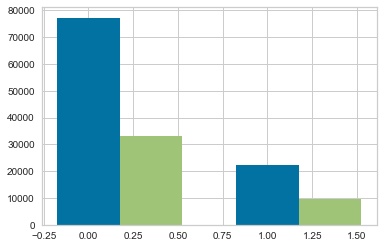

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)
classes_test = ClassBalance(labels=['Yes', 'No'])
classes_test.fit(y_train['Response'], y_test['Response']) 

### Baseline accuracy rates

In [21]:
baseline_accuracy_train, baseline_accuracy_test = (1-y_train[y_train.Response == 1].shape[0]/y_train.shape[0]) , (1-y_test[y_test.Response == 1].shape[0]/y_test.shape[0])
baseline_accuracy_train, baseline_accuracy_test

(0.7764103079318833, 0.7744385578320596)

### Feature Eng 

    - opted for selection via inspection

In [ ]:
#from sklearn.feature_selection import RFE
#rfe = RFE(lgrg, 50)
#rfe = rfe.fit(X_train, y_train.values.ravel())

In [ ]:
#X_train_fe = X_train[X_train.columns[rfe.support_]]
#X_test_fe = X_test[X_test.columns[rfe.support_]]

### Fit a Logistic on all predictors

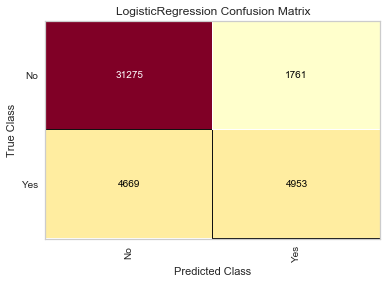

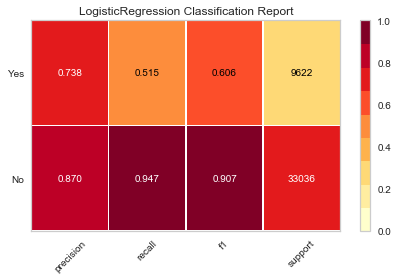

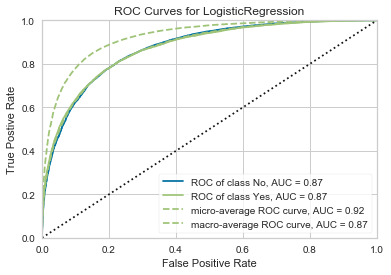

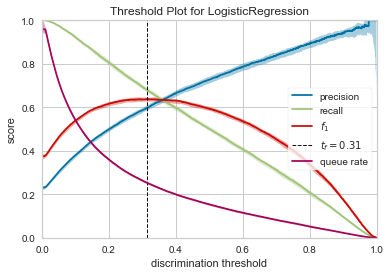

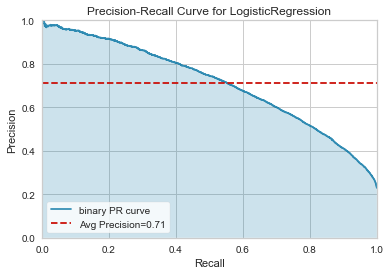

Logit (all features) Accuracy 0.84927
Cutoff (0.4) adjusted accuracy: 0.84427
ProbFalse     0.49988
ProbTrue      0.50012
Predict       1.00000
NewPredict    1.00000
Name: 10663, dtype: float64
ProbFalse     0.599985
ProbTrue      0.400015
Predict       0.000000
NewPredict    1.000000
Name: 21072, dtype: float64
50/50 Accuracy 0.84927 is better than baseline
Cutoff Adjusted Accuracy 0.84427 is better than baseline


,No_Predicted,Yes_Predicted
No_True,30204,2832
Yes_True,3811,5811


In [24]:
lgrg_all = LogisticRegression(C=0.01
                          , solver='liblinear'
                          , dual=False
                          , fit_intercept=True
                          , intercept_scaling=1
                          #, l1_ratio=None
                          , max_iter=100
                          , multi_class='auto'
                          , n_jobs=None
                          , penalty='l2'
                          , random_state=0
                          , tol=0.0001
                          , verbose=0
                          , warm_start=False)

lgrg_all.fit(X_train, y_train.values.ravel())
cutoffs_lgrg_all, scores_lgrg_all = analyze_classifier(lgrg_all, X_train, X_test, y_train, y_test)
predict_logit_all = lgrg_all.predict(X_test)
prob_logit_all = lgrg_all.predict_proba(X_test)
best_cutoff_lgrg_all = 0.4# = pd.Series(cutoffs_lgrg_all)[pd.Series(list(scores_lgrg_all['fscore'])).idxmax()]
adj_acc_logit_all, adj_conf_matrix_logit_all, new_preds_logit_all = compute_new_conf_matrix(predict_logit_all, prob_logit_all, best_cutoff_lgrg_all, y_test)
acc_logit_all = round(accuracy_score(y_test, predict_logit_all),5)
print(f'Logit (all features) Accuracy {acc_logit_all}')
print(f'Cutoff ({round(best_cutoff_lgrg_all,4)}) adjusted accuracy: {adj_acc_logit_all}')
print(new_preds_logit_all.iloc[new_preds_logit_all[new_preds_logit_all.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_logit_all.iloc[new_preds_logit_all[new_preds_logit_all.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_logit_all} is {"better than baseline" if acc_logit_all > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_logit_all} is {"better than baseline" if adj_acc_logit_all > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_logit_all

### Cols chosen from intuition/EDA

In [26]:
X_train_fe = X_train[['Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'RainToday_Yes', 'Season_Winter']]#, 'Season_Summer', 'Season_Fall', 'Season_Spring']]
X_test_fe = X_test[['Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'RainToday_Yes', 'Season_Winter']]#, 'Season_Summer', 'Season_Fall', 'Season_Spring']]

### Basic logistic regression

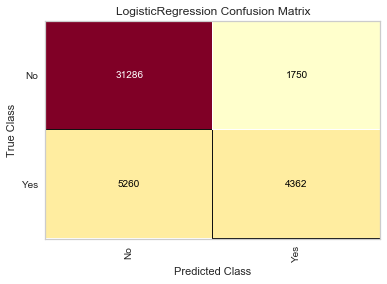

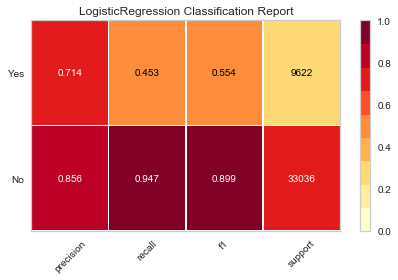

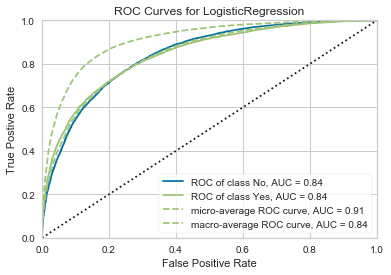

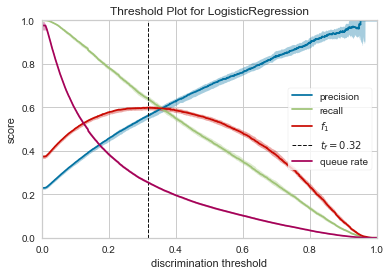

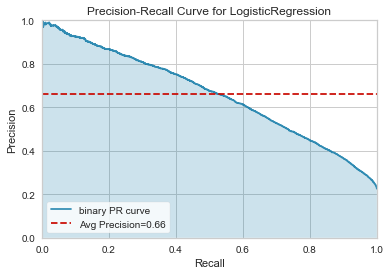

Logit Accuracy 0.83567
Cutoff (0.3152) adjusted accuracy: 0.81031
ProbFalse     0.499879
ProbTrue      0.500121
Predict       1.000000
NewPredict    1.000000
Name: 36916, dtype: float64
ProbFalse     0.684749
ProbTrue      0.315251
Predict       0.000000
NewPredict    1.000000
Name: 20841, dtype: float64
50/50 Accuracy 0.83567 is better than baseline
Cutoff Adjusted Accuracy 0.81031 is better than baseline


,No_Predicted,Yes_Predicted
No_True,28305,4731
Yes_True,3361,6261


In [30]:
lgrg = LogisticRegression(C=0.01
                          , solver='liblinear'
                          , dual=False
                          , fit_intercept=True
                          , intercept_scaling=1
                          #, l1_ratio=None
                          , max_iter=100
                          , multi_class='auto'
                          , n_jobs=None
                          , penalty='l2'
                          , random_state=0
                          , tol=0.0001
                          , verbose=0
                          , warm_start=False)

lgrg.fit(X_train_fe, y_train.values.ravel())
cutoffs_lgrg, scores_lgrg = analyze_classifier(lgrg, X_train_fe, X_test_fe, y_train, y_test)
predict_logit = lgrg.predict(X_test_fe)
prob_logit = lgrg.predict_proba(X_test_fe)
best_cutoff_lgrg = pd.Series(cutoffs_lgrg)[pd.Series(list(scores_lgrg['fscore'])).idxmax()]
adj_acc_logit, adj_conf_matrix_logit, new_preds_logit = compute_new_conf_matrix(predict_logit, prob_logit, best_cutoff_lgrg, y_test)
acc_logit = round(accuracy_score(y_test, predict_logit),5)
print(f'Logit Accuracy {acc_logit}')
print(f'Cutoff ({round(best_cutoff_lgrg,4)}) adjusted accuracy: {adj_acc_logit}')
print(new_preds_logit.iloc[new_preds_logit[new_preds_logit.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_logit.iloc[new_preds_logit[new_preds_logit.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_logit} is {"better than baseline" if acc_logit > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_logit} is {"better than baseline" if adj_acc_logit > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_logit

### LDA 

 - number of components = 1 (# of reponse variables - 1)

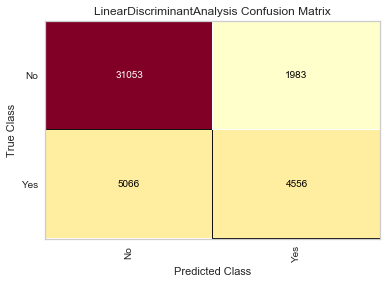

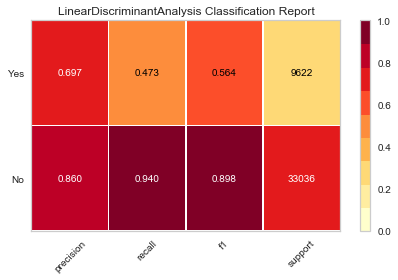

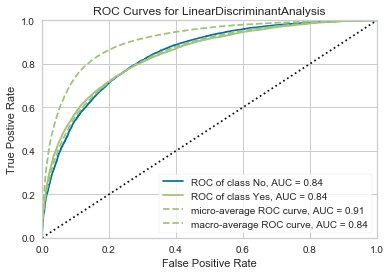

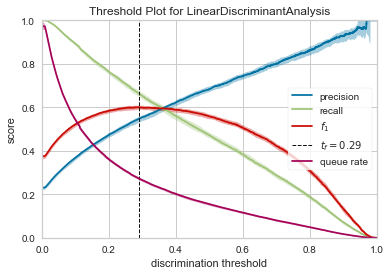

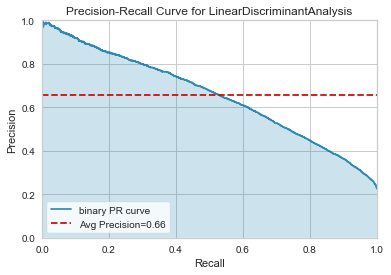

LDA Accuracy 0.83476
Cutoff (0.289) adjusted accuracy: 0.80294
ProbFalse     0.499932
ProbTrue      0.500068
Predict       1.000000
NewPredict    1.000000
Name: 21895, dtype: float64
ProbFalse     0.710896
ProbTrue      0.289104
Predict       0.000000
NewPredict    1.000000
Name: 42199, dtype: float64
50/50 Accuracy 0.83476 is better than baseline
Cutoff Adjusted Accuracy 0.80294 is better than baseline


,No_Predicted,Yes_Predicted
No_True,27780,5256
Yes_True,3150,6472


In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
X_train_continuous = X_train_fe#[[x for x, y in dict(X_train_fe.dtypes).items() if y == np.float64]]
X_test_continuous = X_test_fe#[[x for x, y in dict(X_test_fe.dtypes).items() if y == np.float64]]
lda.fit(X_train_continuous, y_train.values.ravel())
cutoffs_lda, scores_lda = analyze_classifier(lda, X_train_continuous, X_test_continuous, y_train, y_test)
predict_lda = lda.predict(X_test_fe)
prob_lda = lda.predict_proba(X_test_fe)
best_cutoff_lda = pd.Series(cutoffs_lda)[pd.Series(list(scores_lda['fscore'])).idxmax()]
adj_acc_lda, adj_conf_matrix_lda, new_preds_lda = compute_new_conf_matrix(predict_lda, prob_lda, best_cutoff_lda, y_test)
acc_lda = round(accuracy_score(y_test, predict_lda),5)
print(f'LDA Accuracy {acc_lda}')
print(f'Cutoff ({round(best_cutoff_lda,4)}) adjusted accuracy: {adj_acc_lda}')
print(new_preds_lda.iloc[new_preds_lda[new_preds_lda.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_lda.iloc[new_preds_lda[new_preds_lda.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_lda} is {"better than baseline" if acc_lda > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_lda} is {"better than baseline" if adj_acc_lda > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_lda

### QDA

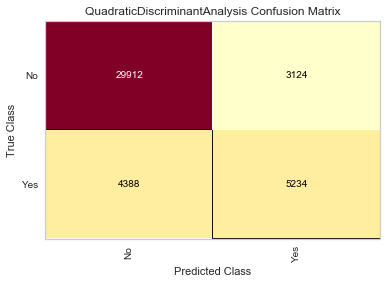

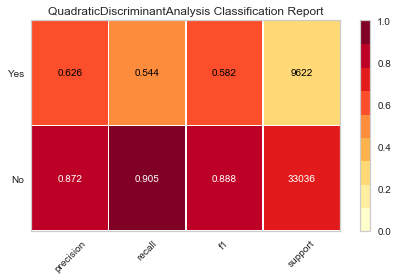

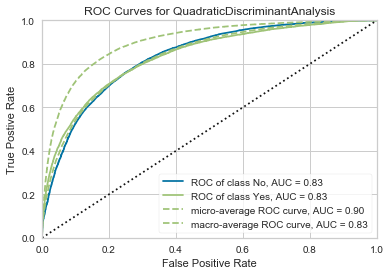

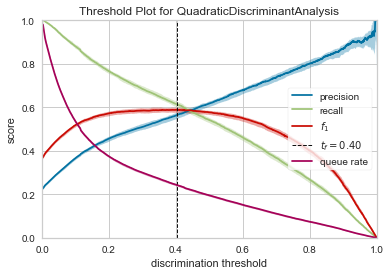

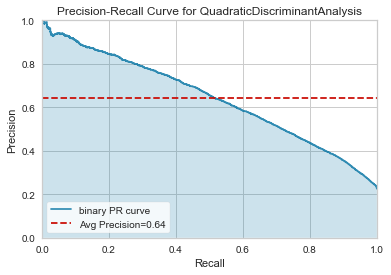

QDA Accuracy 0.8239
Cutoff (0.4019) adjusted accuracy: 0.80965
ProbFalse     0.499942
ProbTrue      0.500058
Predict       1.000000
NewPredict    1.000000
Name: 19185, dtype: float64
ProbFalse     0.59803
ProbTrue      0.40197
Predict       0.00000
NewPredict    1.00000
Name: 32719, dtype: float64
50/50 Accuracy 0.8239 is better than baseline
Cutoff Adjusted Accuracy 0.80965 is better than baseline


,No_Predicted,Yes_Predicted
No_True,28535,4501
Yes_True,3619,6003


In [31]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
qda = QDA()
qda.fit(X_train_continuous, y_train.values.ravel())
cutoffs_qda, scores_qda = analyze_classifier(qda, X_train_continuous, X_test_continuous, y_train, y_test)
predict_qda = qda.predict(X_test_fe)
prob_qda = qda.predict_proba(X_test_fe)
best_cutoff_qda = pd.Series(cutoffs_qda)[pd.Series(list(scores_qda['fscore'])).idxmax()]
adj_acc_qda, adj_conf_matrix_qda, new_preds_qda = compute_new_conf_matrix(predict_qda, prob_qda, best_cutoff_qda, y_test)
acc_qda = round(accuracy_score(y_test, predict_qda),5)
print(f'QDA Accuracy {acc_qda}')
print(f'Cutoff ({round(best_cutoff_qda,4)}) adjusted accuracy: {adj_acc_qda}')
print(new_preds_qda.iloc[new_preds_qda[new_preds_qda.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_qda.iloc[new_preds_qda[new_preds_qda.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_qda} is {"better than baseline" if acc_qda > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_qda} is {"better than baseline" if adj_acc_qda > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_qda

In [32]:
from sklearn.svm import SVC
support_vec_model = SVC(gamma='auto', kernel='linear', C=0.01)
support_vec_model.fit(X_train_fe, y_train.values.ravel())
#analyze_classifier(support_vec_model, X_train_fe, X_test_fe, y_train, y_test)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Naive Bayes

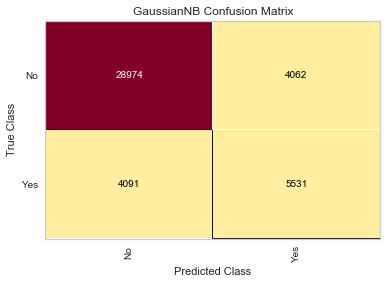

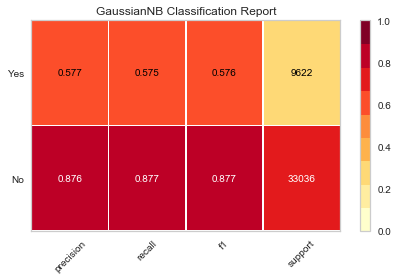

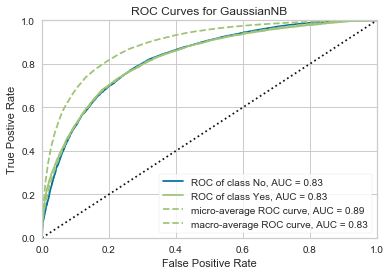

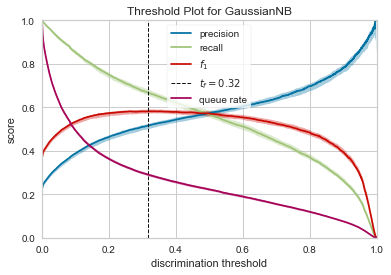

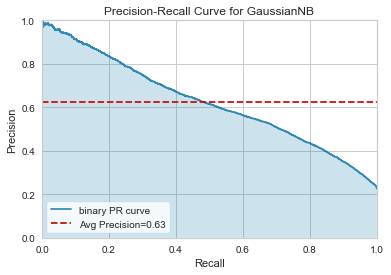

NB Accuracy 0.80888
Cutoff (0.3164) adjusted accuracy: 0.80965
ProbFalse     0.499942
ProbTrue      0.500058
Predict       1.000000
NewPredict    1.000000
Name: 19185, dtype: float64
ProbFalse     0.59803
ProbTrue      0.40197
Predict       0.00000
NewPredict    1.00000
Name: 32719, dtype: float64
50/50 Accuracy 0.80888 is better than baseline
Cutoff Adjusted Accuracy 0.80965 is better than baseline


,No_Predicted,Yes_Predicted
No_True,28535,4501
Yes_True,3619,6003


In [33]:
nb = GaussianNB(
   var_smoothing=1e-9
)
cutoffs_nb, scores_nb = analyze_classifier(nb, X_train_fe, X_test_fe, y_train, y_test)
predict_nb = nb.predict(X_test_fe)
prob_nb = nb.predict_proba(X_test_fe)
best_cutoff_nb = pd.Series(cutoffs_nb)[pd.Series(list(scores_nb['fscore'])).idxmax()]
adj_acc_nb, adj_conf_matrix_nb, new_preds_nb = compute_new_conf_matrix(predict_qda, prob_qda, best_cutoff_qda, y_test)
acc_nb = round(accuracy_score(y_test, predict_nb),5)
print(f'NB Accuracy {acc_nb}')
print(f'Cutoff ({round(best_cutoff_nb,4)}) adjusted accuracy: {adj_acc_nb}')
print(new_preds_nb.iloc[new_preds_nb[new_preds_nb.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_nb.iloc[new_preds_nb[new_preds_nb.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_nb} is {"better than baseline" if acc_nb > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_nb} is {"better than baseline" if adj_acc_nb > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_nb

### Random forest classifier

In [ ]:
rf_classifier = RandomForestClassifier(
  #max_depth=None,
  random_state=0,
  #bootstrap=True,
  #oob_score=True,
  #max_samples = 50,
  criterion='gini',
  n_estimators=200
)
rf_classifier.fit(X_train_fe, y_train.values.ravel())
cutoffs_rf, scores_rf = analyze_classifier(rf_classifier, X_train_fe, X_test_fe, y_train, y_test)
predict_rf = nb.predict(X_test_fe)
prob_rf = nb.predict_proba(X_test_fe)
best_cutoff_rf = pd.Series(cutoffs_rf)[pd.Series(list(scores_rf['fscore'])).idxmax()]
adj_acc_rf, adj_conf_matrix_rf, new_preds_rf = compute_new_conf_matrix(predict_rf, prob_rf, best_cutoff_rf, y_test)
acc_rf = round(accuracy_score(y_test, predict_rf),5)
print(f'RF Accuracy {acc_rf}')
print(f'Cutoff ({round(best_cutoff_rf,4)}) adjusted accuracy: {adj_acc_rf}')
print(new_preds_rf.iloc[new_preds_rf[new_preds_rf.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_rf.iloc[new_preds_rf[new_preds_rf.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_rf} is {"better than baseline" if acc_rf > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_rf} is {"better than baseline" if adj_acc_rf > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_rf

### VIF Factors for Final Model

In [34]:
sklearn_vif(X_train_fe.columns, data_final.drop(columns=['Response']))

,VIF,Tolerance
Cloud3pm,1.209985,0.826456
Humidity3pm,1.373866,0.727873
Pressure3pm,1.080373,0.925606
RainToday_Yes,1.183074,0.845256
Season_Winter,1.082088,0.924139


In [ ]:
#rf.feature_importance_

In [ ]:
roc_curve(y_test, predicted_probs.NewPredict)

In [ ]:
roc_auc_score(y_test, predicted_probs.NewPredict)

In [ ]:
vif = sklearn_vif(features.columns, data_final.drop(columns=['Response']))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Best parameter (CV score=0.848):
{'logistic__C': 10000.0, 'pca__n_components': 131}


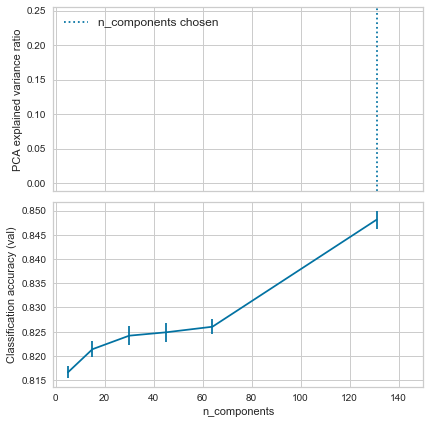

In [42]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
#logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pre-process',StandardScaler()), ('pca', pca), ('logistic', lgrg_all)])

#X, y = datasets.load_digits(return_X_y=True)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64, 131],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train.values.ravel())
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 150)

plt.tight_layout()
plt.show()

In [45]:
pca.explained_variance_ratio_.sum()

0.9999999999999999